In [467]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from collections import defaultdict
import pandas as pd

def bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold=0.65, local_segment=[0,0], animate=False):
    # Initialize the system
    fitness = np.random.rand(n_species)
    # threshold = 0.65
    gap_function_value = 0
    min_fitness = np.zeros(n_iterations - skip_iterations)
    fitness_history = []
    avalanche_sizes_local = []
    avalanche_sizes_global = []
    avalanche_activity_local = []
    avalanche_activity_global = []
    avalanche = False
    avalanche_size_local = 0
    avalanche_size_global = 0
    animating = True
    animation_list = []
    animation_front_buffer = []
    animation_front_buffer_length = 50
    animation_after_buffer = []
    animation_after_buffer_length = 50
    animation_start = False
    

    for i in range(n_iterations):
        # species with minimum fitness value
        min_index = np.argmin(fitness)

        # assign a new random fitness value to the selected species
        fitness[min_index] = np.random.rand()

        # update neighbor fitness      
        fitness[min_index - 1] = np.random.rand()
        
        if min_index < n_species - 1:
            fitness[min_index + 1] = np.random.rand()
        # periodic boundary
        elif min_index == n_species -1:
            fitness[0] = np.random.rand()

        min_fitness_value = np.min(fitness)
        # if min_fitness_value > gap_function_value:
        #     gap_function_value = min_fitness_value
        #     # print(f'{gap_function_value}, iteration: {i}')
        #     threshold = gap_function_value - 0.01
        
        # skip iterations to start at the critical state
        if i >= skip_iterations:
            fitness_history.append(fitness)

            if animation_start == False and animating == True and animate == True:
                # add to buffer to record behaviour before avalanche
                animation_front_buffer.append(fitness)

                # keep the buffer to a certain length
                if len(animation_front_buffer) > animation_front_buffer_length:
                    animation_front_buffer.pop(0)
            
            # save minimum fitness for each iteration
            min_fitness[i - skip_iterations] = min_fitness_value

            # if avalanche in progress
            if min_fitness_value < threshold and avalanche == True:
                # seperate counter for local activity
                if min_index >= local_segment[0] and min_index < local_segment[1]:
                    avalanche_size_local += 1
                    avalanche_activity_local.append(i-skip_iterations)

                avalanche_size_global += 1
                avalanche_activity_global.append(i-skip_iterations)

                # add frame to animation
                if animating == True and animate == True:
                    animation_list.append(list(fitness))

                if animating == False and len(animation_after_buffer) < animation_after_buffer_length:
                    animation_after_buffer.append(fitness)
                    

            # start of new avalanche
            if min_fitness_value < threshold and avalanche == False:
                # animate avalanche
                if animating == True and animate == True:
                    animation_list = []
                    animation_list.append(list(fitness))
                avalanche = True
                animation_start = True

                if animating == False and len(animation_after_buffer) < animation_after_buffer_length:
                    animation_after_buffer.append(fitness)

            # end of an avalanche
            if min_fitness_value >= threshold and avalanche == True:

                avalanche_sizes_local.append(avalanche_size_local)
                avalanche_sizes_global.append(avalanche_size_global)
                avalanche_size_local = 0
                avalanche_size_global = 0
                avalanche = False

                # turn off animation only with a big avalanche
                if len(animation_list) > 50 and len(animation_list) < 1001 and animating == True and animate == True and len(animation_front_buffer) > 20:
                    animating = False
                else:
                    animation_front_buffer = []

                animation_start = False

                if animating == False and len(animation_after_buffer) < animation_after_buffer_length:
                    animation_after_buffer.append(fitness)
                
                    


    return min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, animation_list, animation_front_buffer, animation_after_buffer



In [468]:
# Run the Bak-Sneppen simulation
n_iterations = 40000
skip_iterations = 20000
local_segment = [10,20]
n_species = 50
avalanche_sizes_local = [0,0]
animation_list = []
threshold = 0.65
animate = True

counter = 0
while sum(x != 0 for x in avalanche_sizes_local) < 1:
    counter += 1
    print(f'{counter}, {sum(x != 0 for x in avalanche_sizes_local)}', end='\r')
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, animation_avalanche, animation_buffer_front, animation_buffer_after = bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold, local_segment, animate)

animation_list = animation_buffer_front + animation_avalanche + animation_buffer_after


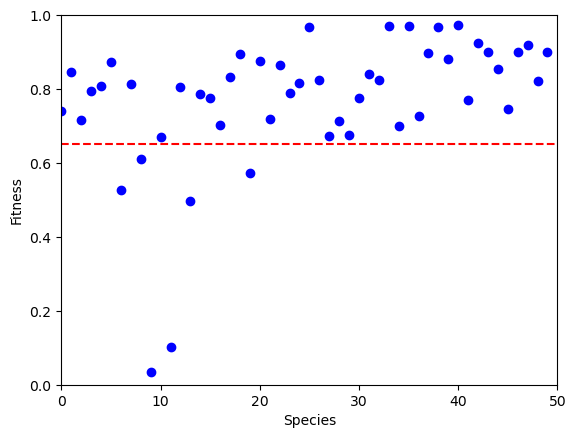

In [466]:
import matplotlib.animation as animation
# animation_list = animation_buffer_front

# Sample x and y lists
species_locations = [[x for x in range(0, n_species)]] * len(animation_list)

# Set the frames per second (fps)
fps = 5

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty plot
points, = ax.plot([], [], 'bo')
line, = ax.plot([], [], 'r--')  # Create a line plot for the threshold

# Set the axes limits
ax.set_xlim(0, n_species)
ax.set_ylim(0, 1)
ax.set_xlabel("Species")
ax.set_ylabel("Fitness")

# iteration_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Set the threshold value
threshold = 0.65

# Function to update the plot for each frame
def update(frame):
    # Get the x and y values for the current frame
    y = animation_list[frame]
    x = species_locations[frame]

    # Update the data of the plot
    points.set_data(x, y)

    # custom_number = 'start - {}'.format(-1 * len(animation_buffer_front) + frame)
    # iteration_text.set_text(custom_number)

    # Update the threshold line
    line.set_data([0, n_species], [threshold, threshold])

    return points, line#, iteration_text

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(animation_list), interval=1000/fps)

# Save the animation as a GIF file
ani.save('animation.gif', writer='pillow')

# Display the animation
plt.show()

75


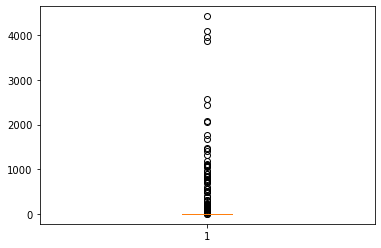

In [62]:
print(sum(x != 0 for x in avalanche_sizes_local))
plt.boxplot(avalanche_sizes_local)
plt.show()

Local avalanche activity

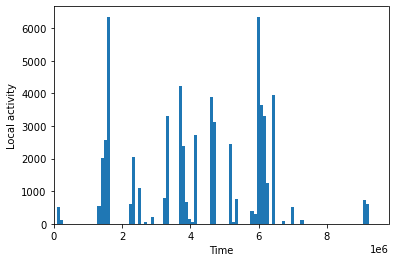

In [63]:
# plot avalanche activity in time
plt.hist(avalanche_activity_local, bins=100)
plt.xlim(0,n_iterations-skip_iterations)
plt.xlabel('Time')
plt.ylabel('Local activity')
plt.show()

Avalanche size distribution

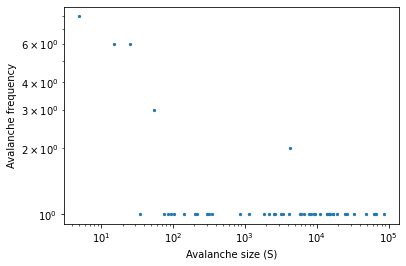

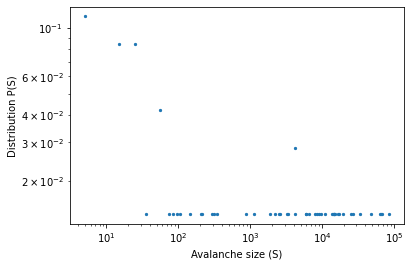

In [73]:
bin_size = 10

# bins of avalanche sizes
bins = [x for x in np.arange(0, np.max(avalanche_sizes_global), bin_size)]
all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_global) - bin_size, bin_size)]
avalanche_size_distribution, _ = np.histogram(avalanche_sizes_global, bins)



# remove bins were value is zero
avalanche_size_distribution_plot = []
bins_plot = []
for i in range(len(avalanche_size_distribution)):
    if avalanche_size_distribution[i] != 0:
        avalanche_size_distribution_plot.append(avalanche_size_distribution[i])
        bins_plot.append(all_bins[i])



# print(avalanche_size_distribution_plot)
# print(bins_plot)
# print(len(avalanche_sizes_global))


plt.scatter(bins_plot, avalanche_size_distribution_plot, s=5)
# plt.hist(avalanche_sizes_global, bins=100)
plt.xlabel('Avalanche size (S)')
plt.ylabel('Avalanche frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

# bins of avalanche sizes
bins = [x for x in np.arange(0, np.max(avalanche_sizes_global), bin_size)]
all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_global) - bin_size, bin_size)]
avalanche_size_distribution, _ = np.histogram(avalanche_sizes_global, bins)

# normalize (frequency => probability)
total_avalanches = len(avalanche_sizes_global)
avalanche_distribution = []
for avalanche in avalanche_size_distribution:
    avalanche_distribution.append(avalanche/total_avalanches)


# remove bins were value is zero
avalanche_size_distribution_plot = []
bins_plot = []
for i in range(len(avalanche_distribution)):
    if avalanche_distribution[i] != 0:
        avalanche_size_distribution_plot.append(avalanche_distribution[i])
        bins_plot.append(all_bins[i])



# print(avalanche_size_distribution_plot)
# print(bins_plot)
# print(len(avalanche_sizes_global))


plt.scatter(bins_plot, avalanche_size_distribution_plot, s=5)
# plt.hist(avalanche_sizes_global, bins=100)
plt.xlabel('Avalanche size (S)')
plt.ylabel('Distribution P(S)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# # mean avalanche size for each avalance size probability
# avalanche_size_bins = bins_plot
# avalanche_size_distribution_plot = avalanche_size_distribution_plot

# data_dict = defaultdict(list)

# for x, y in zip(avalanche_size_bins, avalanche_size_distribution_plot):
#     data_dict[y].append(x)

# mean_size_distribution = []
# mean_avalanche_sizes = []

# for y, x_list in data_dict.items():
#     mean_size_distribution.append(y)
#     mean_x = sum(x_list) / len(x_list)
#     mean_avalanche_sizes.append(mean_x)


# print('Mean of avalanche sizes for each avalanche size probability:')
# plt.scatter(mean_avalanche_sizes, mean_size_distribution, s=5)
# # plt.hist(avalanche_sizes_global, bins=100)
# plt.xlabel('Avalanche size (S)')
# plt.ylabel('Distribution P(S)')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

In [18]:
# run simulation for different system sizes to compare
system_sizes = [32, 128, 512, 2048]
n_iterations = 10000000
skip_iterations = 200000
threshold = 0.6

avalanche_sizes_list = []

for n_species in system_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, _ = bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold, local_segment)
    avalanche_sizes_list.append(avalanche_sizes_global)


KeyboardInterrupt: 

IndexError: list index out of range

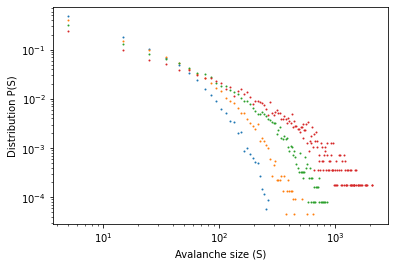

In [25]:
# system_sizes = [32, 128, 512, 2048]

# for i in range(len(avalanche_sizes_list)):
#     # bins of avalanche sizes
#     bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
#     all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
#     avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    

#     # remove bins were value is zero
#     avalanche_size_distribution_plot = []
#     bins_plot = []
#     for j in range(len(avalanche_size_distribution)):
#         if avalanche_size_distribution[j] != 0:
#             avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
#             bins_plot.append(all_bins[j])


#     # print(avalanche_size_distribution_plot)
#     # print(bins_plot)
#     # print(len(avalanche_sizes_global))
    

#     plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'N = {system_sizes[i]}', s=1)
#     plt.xlabel('Avalanche size (S)')
#     plt.ylabel('Distribution P(S)')
#     plt.xscale('log')
#     plt.yscale('log')
# plt.legend()
# plt.show()

# normalized version
for i in range(len(avalanche_sizes_list)):
    # bins of avalanche sizes
    bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
    all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
    avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    
    # normalize (frequency => probability)
    total_avalanches = len(avalanche_sizes_list[i])
    avalanche_distribution = []
    for avalanche in avalanche_size_distribution:
        avalanche_distribution.append(avalanche/total_avalanches)

    # remove bins were value is zero
    avalanche_size_distribution_plot = []
    bins_plot = []
    for j in range(len(avalanche_distribution)):
        if avalanche_distribution[j] != 0:
            avalanche_size_distribution_plot.append(avalanche_distribution[j])
            bins_plot.append(all_bins[j])


    # print(avalanche_size_distribution_plot)
    # print(bins_plot)
    # print(len(avalanche_sizes_global))
    

    plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'N = {system_sizes[i]}', s=1)
    plt.xlabel('Avalanche size (S)')
    plt.ylabel('Distribution P(S)')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()



In [ ]:
import powerlaw

# Example avalanche size data
avalanche_sizes = avalanche_sizes_list[3]

# Set the desired lower bound (xmin)
xmin = 10

# Fit a power-law distribution with the specified xmin
fit = powerlaw.Fit(avalanche_sizes, xmin=xmin)
alpha = fit.alpha

# Plot the data and fitted line in a log-log plot
fit.plot_pdf(color='blue', linewidth=2)
fit.power_law.plot_pdf(color='red', linestyle='--')
plt.xlabel('Avalanche Size')
plt.ylabel('Probability Density')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Fitted Distribution', 'Power-Law Fit'])
plt.show()

# Print the estimated power-law exponent
print('Power-law exponent:', alpha)

average to make plot more line like

In [ ]:
system_sizes = [32, 128, 512, 2048]

for i in range(len(avalanche_sizes_list)):
    # bins of avalanche sizes
    bins = [x for x in np.arange(0,np.max(avalanche_sizes_list[i]),10)]
    all_bins = [x for x in np.arange(5,np.max(avalanche_sizes_list[i]) - 10,10)]
    avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)

    # remove bins were value is zero
    avalanche_size_distribution_plot = []
    avalanche_size_bins = []
    for j in range(len(avalanche_size_distribution)):
        if avalanche_size_distribution[j] != 0:
            avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
            avalanche_size_bins.append(all_bins[j])


    data_dict = defaultdict(list)

    for x, y in zip(avalanche_size_bins, avalanche_size_distribution_plot):
        data_dict[y].append(x)

    mean_size_distribution = []
    mean_avalanche_sizes = []

    for y, x_list in data_dict.items():
        mean_size_distribution.append(y)
        mean_x = sum(x_list) / len(x_list)
        mean_avalanche_sizes.append(mean_x)
    

    plt.scatter(mean_avalanche_sizes, mean_size_distribution, label=f'N = {system_sizes[i]}', s=5)
    # plt.plot(mean_avalanche_sizes, mean_size_distribution, label=f'N = {system_sizes[i]}')
    plt.xlabel('Avalanche size (S)')
    plt.ylabel('Distribution P(S)')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()

Threshold variation

In [446]:
# run simulation for different system sizes to compare
thresholds = [x for x in np.arange(0.59, 0.65, 0.03)]
system_size = 265
n_iterations = 5000000
skip_iterations = 200000
local_segment = [0,1]

count = 0
avalanche_sizes_list = []

for threshold in thresholds:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, _ = bak_sneppen_1D(n_iterations, skip_iterations, system_size, threshold, local_segment)
    avalanche_sizes_list.append(list(avalanche_sizes_global))

        

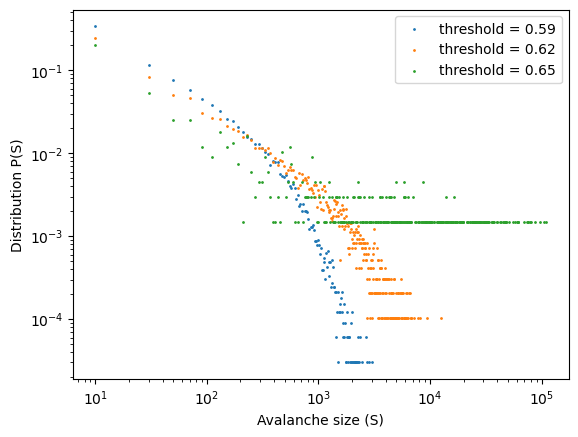

In [450]:
thresholds = [x for x in np.arange(0.59, 0.65, 0.03)]

# for i in range(len(avalanche_sizes_list)):
#     # bins of avalanche sizes
#     bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
#     all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
#     avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    

#     # remove bins were value is zero
#     avalanche_size_distribution_plot = []
#     bins_plot = []
#     for j in range(len(avalanche_size_distribution)):
#         if avalanche_size_distribution[j] != 0:
#             avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
#             bins_plot.append(all_bins[j])


#     # print(avalanche_size_distribution_plot)
#     # print(bins_plot)
#     # print(len(avalanche_sizes_global))
    

#     plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'threshold = {round(thresholds[i],2)}', s=3)
#     plt.xlabel('Avalanche size (S)')
#     plt.ylabel('Distribution P(S)')
#     plt.xscale('log')
#     plt.yscale('log')
# plt.legend()
# plt.show()

# normalized version
bin_size = 20
for i in range(len(avalanche_sizes_list)):
    # bins of avalanche sizes
    bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
    all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
    avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    
    # normalize (frequency => probability)
    total_avalanches = len(avalanche_sizes_list[i])
    avalanche_distribution = []
    for avalanche in avalanche_size_distribution:
        avalanche_distribution.append(avalanche/total_avalanches)

    # remove bins were value is zero
    avalanche_size_distribution_plot = []
    bins_plot = []
    for j in range(len(avalanche_distribution)):
        if avalanche_distribution[j] != 0:
            avalanche_size_distribution_plot.append(avalanche_distribution[j])
            bins_plot.append(all_bins[j])


    # print(avalanche_size_distribution_plot)
    # print(bins_plot)
    # print(len(avalanche_sizes_global))
    

    plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'threshold = {thresholds[i]}', s=1)
    plt.xlabel('Avalanche size (S)')
    plt.ylabel('Distribution P(S)')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()

Power law fit

302
302
70
70


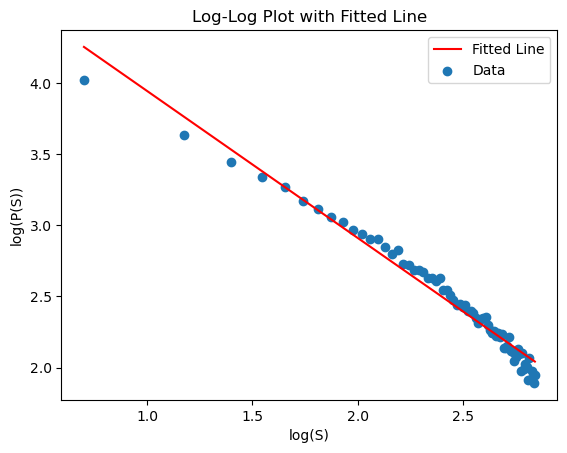

Exponent: -1.0325829090175775


In [272]:
import numpy as np
import matplotlib.pyplot as plt

bins = [x for x in np.arange(0,np.max(avalanche_sizes_list[i]),10)]
all_bins = [x for x in np.arange(5,np.max(avalanche_sizes_list[i]) - 10,10)]
avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[3], bins)

# remove bins were value is zero
avalanche_size_distribution_plot = []
bins_plot = []
for j in range(len(avalanche_size_distribution)):
    if avalanche_size_distribution[j] != 0:
        avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
        bins_plot.append(all_bins[j])


print(len(bins_plot))
print(len(avalanche_size_distribution_plot))


threshold = 700

bins_filtered = [value1 for value1 in bins_plot if value1 <= threshold]
avalanche_sizes_global_filtered = [value2 for value1, value2 in zip(bins_filtered, avalanche_size_distribution_plot) if value1 <= threshold]

print(len(bins_filtered))
print(len(avalanche_sizes_global_filtered))


# Take the logarithm of the filtered data
log_bins = np.log10(bins_filtered)
log_sizes = np.log10(avalanche_sizes_global_filtered)

# Fit a straight line through linear regression
coefficients = np.polyfit(log_bins, log_sizes, 1)
exponent = coefficients[0]

# Generate the fitted line
fit_x = np.linspace(min(log_bins), max(log_bins), 100)
fit_y = coefficients[0] * fit_x + coefficients[1]

# Plot the log-log data and the fitted line
plt.scatter(log_bins, log_sizes, label='Data')
plt.plot(fit_x, fit_y, 'r-', label='Fitted Line')
plt.xlabel('log(S)')
plt.ylabel('log(P(S))')
plt.title('Log-Log Plot with Fitted Line')
plt.legend()
plt.show()

# Print the exponent of the fitted line
print("Exponent:", exponent)

In [262]:

filtered_list = [value for value in avalanche_sizes_list[3] if value <= 1400]
results = powerlaw.Fit(filtered_list)

# Print the estimated exponent and lower bound of the power law distribution
print("Estimated exponent (alpha):", results.power_law.alpha)
print("Estimated lower bound (xmin):", results.power_law.xmin)
print(f"exponent error: {results.power_law.sigma}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Estimated exponent (alpha): 3.1904519128912083
Estimated lower bound (xmin): 452.0
exponent error: 0.028607096200813503


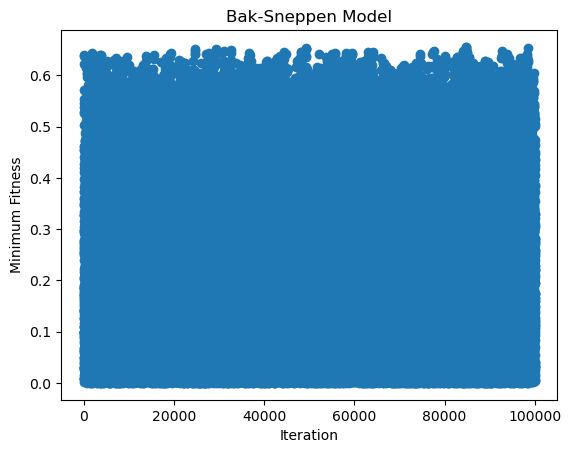

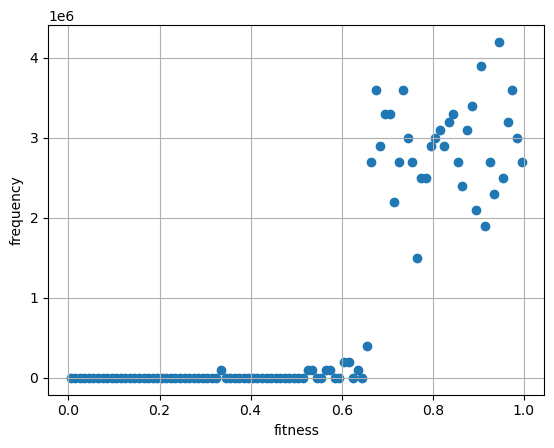

In [92]:

# Plot the evolution of the minimum fitness value
plt.scatter(range(n_iterations - skip_iterations), min_fitness)
plt.xlabel('Iteration')
plt.ylabel('Minimum Fitness')
plt.title('Bak-Sneppen Model')
plt.show()

bins = np.arange(0,1.01,0.01)
bins_plot = np.arange(0.005,1.005,0.01)
counts = np.zeros(len(bins)-1)

# Plot the distribution of fitness during the whole simulation
for fitness_slice in fitness_history:
    counts_slice, _ = np.histogram(fitness_slice, bins)
    counts = [x + y for x, y in zip(counts, counts_slice)]

# Plot the normalized distribution using a histogram
plt.scatter(bins_plot, counts)
plt.xlabel('fitness')
plt.ylabel('frequency')
plt.grid(True)
plt.show()


In [20]:
l1 = np.array([1,2,3])
l2 = np.array([1,2,3])

l1 = [x + y for x, y in zip(l1, l2)]
print(l1)

[2, 4, 6]


2D grid

In [484]:
import powerlaw

def bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold, local_segment=[0,0]):
    # Initialize the system
    # threshold = 0.3
    gap_function_value = 0
    min_fitness = np.zeros(n_iterations - skip_iterations)
    fitness_history = []
    avalanche_sizes_local = []
    avalanche_sizes_global = []
    avalanche_activity_local = []
    avalanche_activity_global = []
    avalanche = False
    # avalanche_size_local = 0
    avalanche_size_global = 0
    fitness_grid = np.random.rand(grid_size, grid_size)

    for i in range(n_iterations):
        # species with minimum fitness value
        min_indices = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)

        # assign a new random fitness value to the least fit species
        fitness_grid[min_indices[0]][min_indices[1]] = np.random.rand()

        # change 4 nearest neighbors
        try:
            fitness_grid[(min_indices[0] + 1) % grid_size][min_indices[1] % grid_size] = np.random.rand()
            fitness_grid[min_indices[0] - 1][min_indices[1] % grid_size] = np.random.rand()
            fitness_grid[min_indices[0] % grid_size][(min_indices[1] + 1) % grid_size] = np.random.rand()
            fitness_grid[min_indices[0] % grid_size][min_indices[1] - 1] = np.random.rand()
        except IndexError:
            print(min_indices)

            raise 'a'

        # min_fitness_value = min(fitness_grid)
        # if min_fitness_value > gap_function_value:
        #     gap_function_value = min_fitness_value
        #     # print(f'{gap_function_value}, iteration: {i}')
        #     threshold = gap_function_value - 0.01
        
        # skip iterations to start at the critical state
        if i  >= skip_iterations:
            # fitness_history.append(fitness_grid)
            
            min_indices = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)

            # save minimum fitness for each iteration
            min_fitness_value = fitness_grid[min_indices[0]][min_indices[1]]
            min_fitness[i - skip_iterations] = min_fitness_value

            # if avalanche in progress
            if min_fitness_value < threshold and avalanche == True:
                # seperate counter for local activity
                # if min_index >= local_segment[0] and min_index < local_segment[1]:
                #     avalanche_size_local += 1
                #     avalanche_activity_local.append(i-skip_iterations)

                avalanche_size_global += 1
                avalanche_activity_global.append(i-skip_iterations)

            # start of new avalanche
            if min_fitness_value < threshold and avalanche == False:
                # print(f'avalanche start i: {i}')
                # avalanche_size += 1
                avalanche = True

            # end of an avalanche
            if min_fitness_value >= threshold and avalanche == True:
                # print(f'avalanche end i: {i}')

                # avalanche_sizes_local.append(avalanche_size_local)
                avalanche_sizes_global.append(avalanche_size_global)
                # avalanche_size_local = 0
                avalanche_size_global = 0
                avalanche = False


    return min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local



2D threshold variation

In [488]:
# run simulation for different system sizes to compare
thresholds_2D = [x for x in np.arange(0.25, 0.32, 0.01)]
grid_size = 50
n_iterations = 500000
skip_iterations = 20000
local_segment = [0,1]

count = 0
avalanche_sizes_list = []

for threshold in thresholds_2D:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold, local_segment)
    avalanche_sizes_list.append(list(avalanche_sizes_global))

Gap function 2D

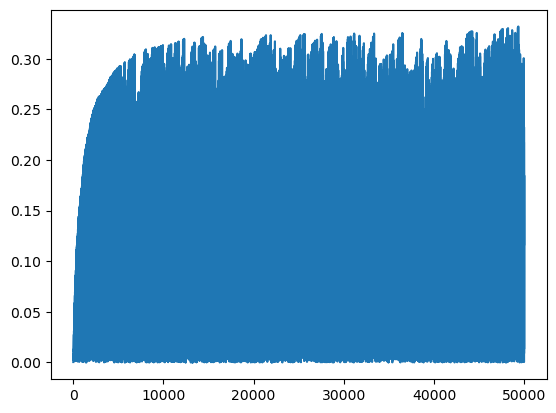

In [487]:
plt.plot([x for x in range(n_iterations)], min_fitness)
plt.show()

49
49


ValueError: x and y must be the same size

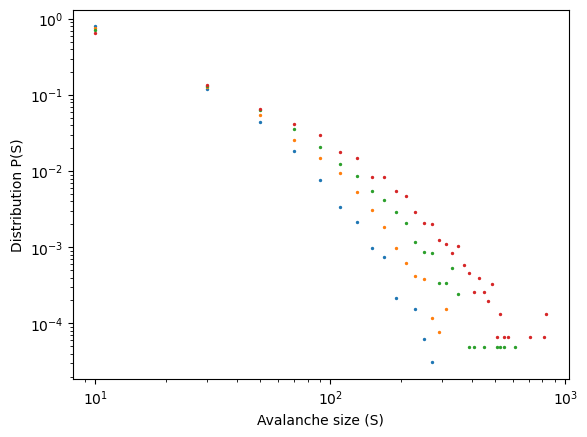

In [490]:
thresholds_2D = [x for x in np.arange(0.25, 0.32, 0.01)]


# for i in range(len(avalanche_sizes_list)):
#     # bins of avalanche sizes
#     bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
#     all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
#     avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    

#     # remove bins were value is zero
#     avalanche_size_distribution_plot = []
#     bins_plot = []
#     for j in range(len(avalanche_size_distribution)):
#         if avalanche_size_distribution[j] != 0:
#             avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
#             bins_plot.append(all_bins[j])


#     # print(avalanche_size_distribution_plot)
#     # print(bins_plot)
#     # print(len(avalanche_sizes_global))
    

#     plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'threshold = {round(thresholds[i],2)}', s=3)
#     plt.xlabel('Avalanche size (S)')
#     plt.ylabel('Distribution P(S)')
#     plt.xscale('log')
#     plt.yscale('log')
# plt.legend()
# plt.show()

# normalized version
bin_size = 20
for i in range(len(avalanche_sizes_list)):
    # bins of avalanche sizes
    bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
    all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
    avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
    
    # normalize (frequency => probability)
    total_avalanches = len(avalanche_sizes_list[i])
    avalanche_distribution = []
    for avalanche in avalanche_size_distribution:
        avalanche_distribution.append(avalanche/total_avalanches)

    # remove bins were value is zero
    avalanche_size_distribution_plot = []
    bins_plot = []
    for j in range(len(avalanche_distribution)):
        if avalanche_distribution[j] != 0:
            avalanche_size_distribution_plot.append(avalanche_distribution[j])
            try:
                bins_plot.append(all_bins[j])
            except IndexError:
                print(j)
                print(len(all_bins))


    # print(avalanche_size_distribution_plot)
    # print(bins_plot)
    # print(len(avalanche_sizes_global))
    

    plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'threshold = {thresholds_2D[i]}', s=2)
    plt.xlabel('Avalanche size (S)')
    plt.ylabel('Distribution P(S)')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()